# Datathon Crushers Source Code
## Problem Statement
We want to find optimal time to go on ski holiday
* We will be looking at prices, visitor numbers, min/max temperatures.
* We want to find the one week and one resort in 2026 where all these factors align for the ultimate holiday!


In [69]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
from darts.models import AutoARIMA
from darts.metrics import mape
from statsmodels.tsa.statespace.sarimax import SARIMAX
import gc

In [3]:
xls = pd.ExcelFile("2025 Allianz Datathon Dataset.xlsx")

In [4]:
visitDataRaw = xls.parse('Visitation Data')
visitDataRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Year            165 non-null    int64
 1   Week            165 non-null    int64
 2   Mt. Baw Baw     165 non-null    int64
 3   Mt. Stirling    165 non-null    int64
 4   Mt. Hotham      165 non-null    int64
 5   Falls Creek     165 non-null    int64
 6   Mt. Buller      165 non-null    int64
 7   Selwyn          165 non-null    int64
 8   Thredbo         165 non-null    int64
 9   Perisher        165 non-null    int64
 10  Charlotte Pass  165 non-null    int64
dtypes: int64(11)
memory usage: 14.3 KB


### Inference
* n = 165 observations
* No missing values
* All attributes are numerical

In [6]:
visitDataRaw.describe()

,Year,Week,Mt. Baw Baw,Mt. Stirling,Mt. Hotham,Falls Creek,Mt. Buller,Selwyn,Thredbo,Perisher,Charlotte Pass
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,2019.000000,8.000000,5373.648485,589.981818,20110.333333,24027.145455,29349.296970,5536.533333,30020.884848,39649.515152,2181.812121
std,3.171904,4.333646,3924.269031,529.497558,12198.935589,14176.688461,17768.711945,3383.338655,18363.819945,24258.783674,1334.790842
min,2014.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,4.000000,1757.000000,98.000000,8368.000000,8741.000000,12397.000000,2180.000000,11543.000000,15236.000000,842.000000
50%,2019.000000,8.000000,5565.000000,480.000000,21856.000000,28099.000000,33328.000000,6454.000000,34676.000000,46265.000000,2542.000000
75%,2022.000000,12.000000,8513.000000,962.000000,30944.000000,36692.000000,44315.000000,8530.000000,46015.000000,60788.000000,3344.000000
max,2024.000000,15.000000,18031.000000,2097.000000,44648.000000,49697.000000,66326.000000,12863.000000,70634.000000,93226.000000,5033.000000


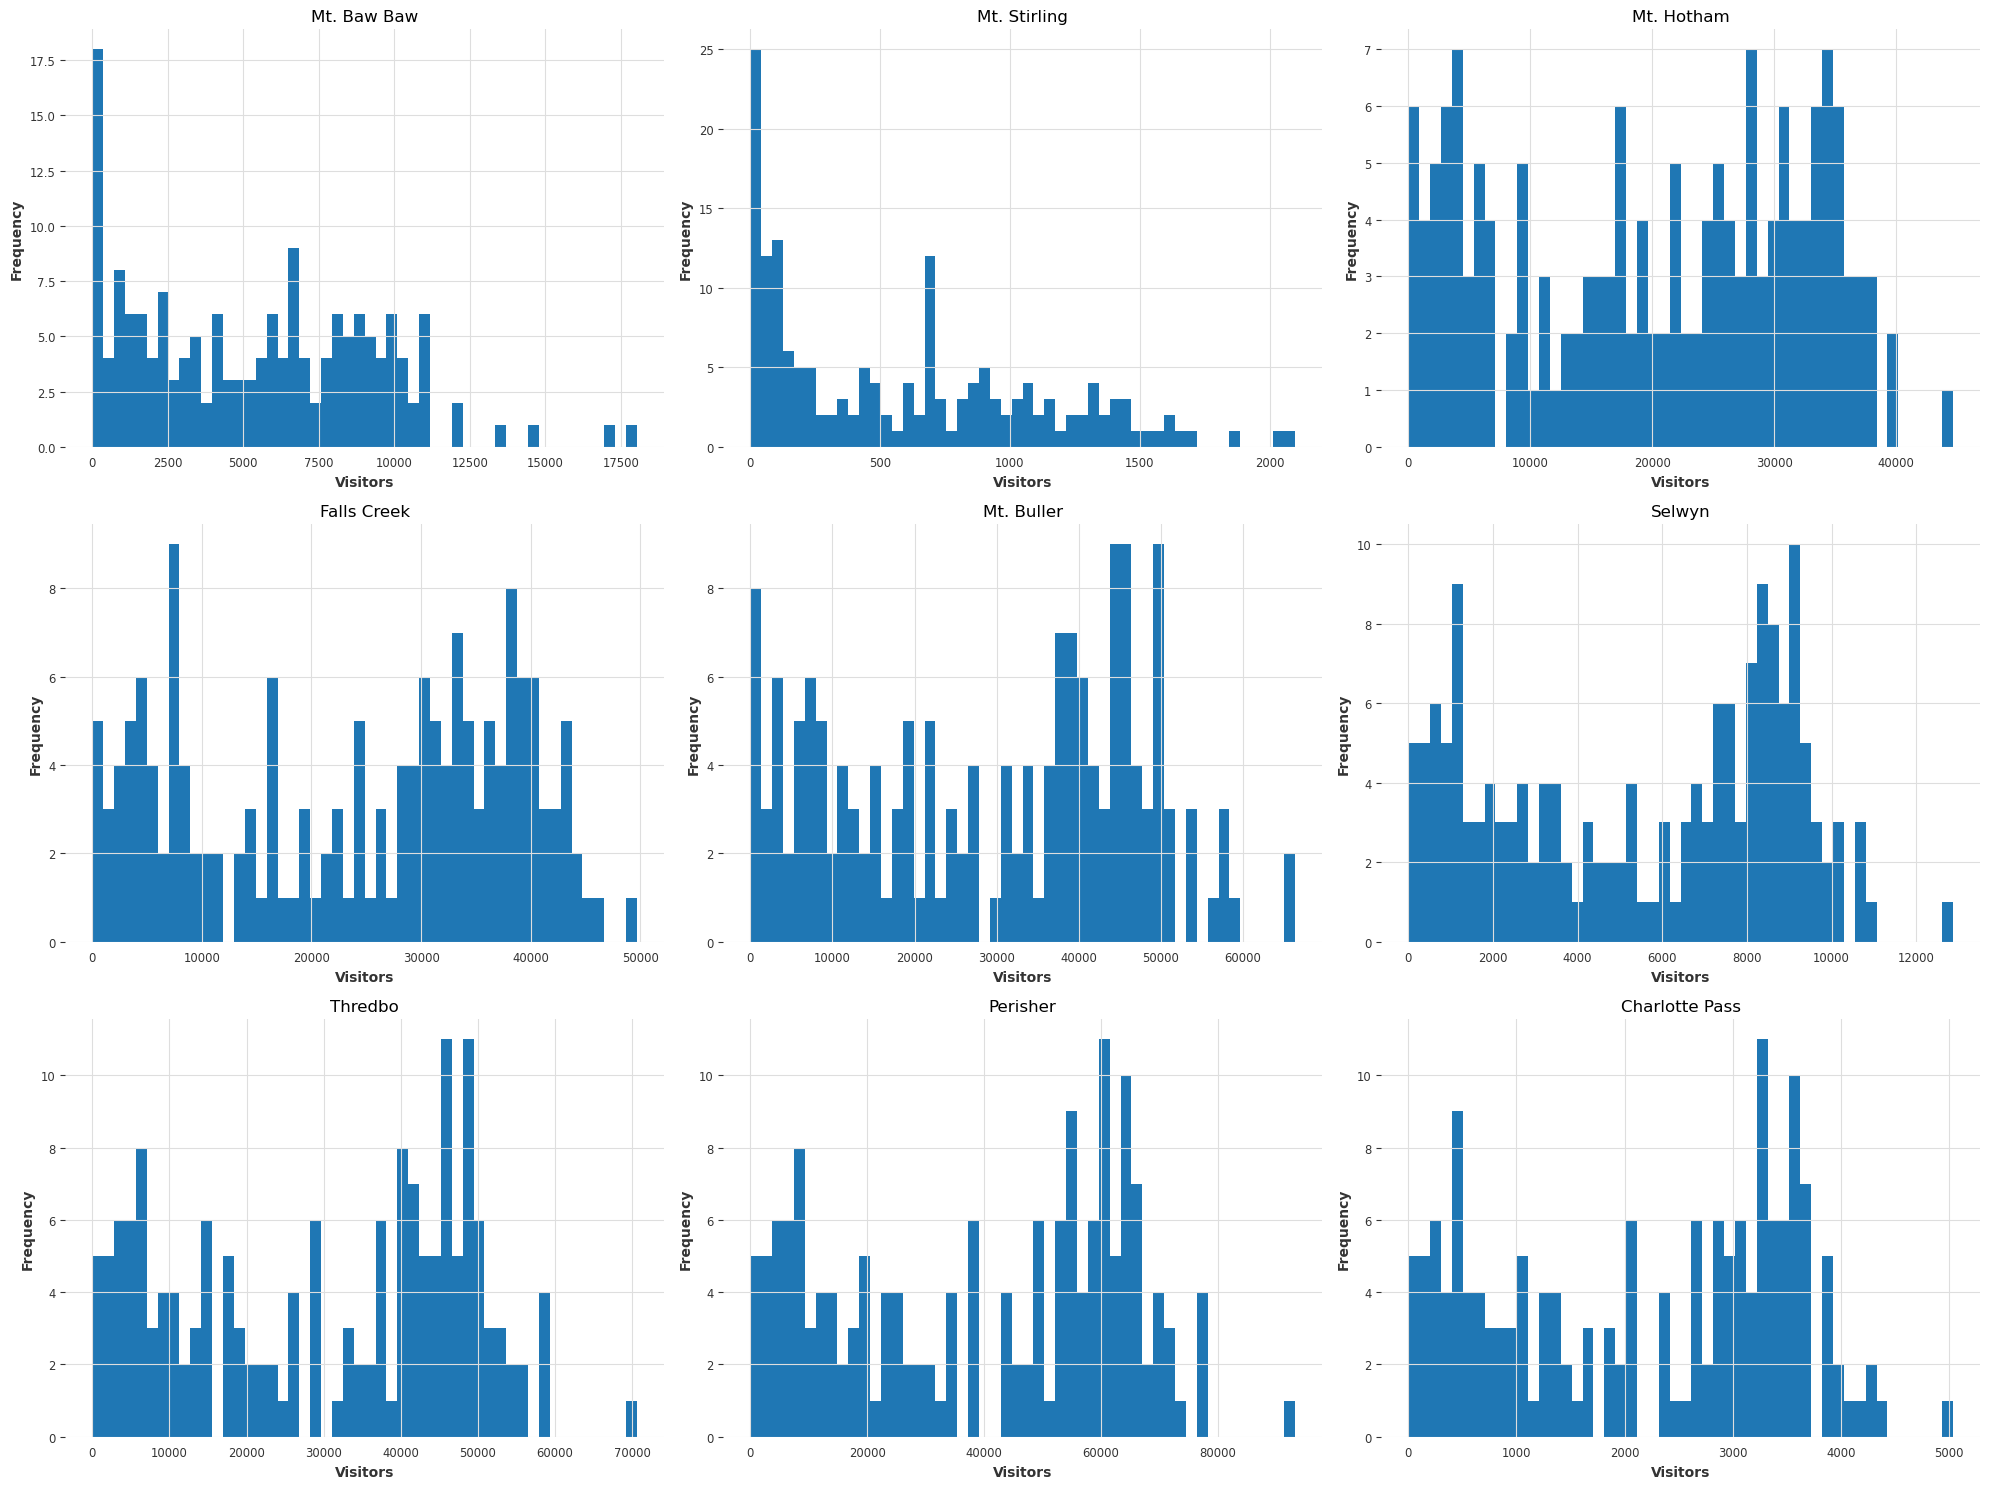

In [7]:
fig = visitDataRaw.iloc[:, 2:].hist(bins=50, figsize=(20, 15), color = '#1f77b4')

for ax_row in fig:
    for ax in ax_row:
        ax.set_xlabel("Visitors")
        ax.set_ylabel("Frequency")
        
plt.tight_layout()
plt.savefig("overall_analysis.png", dpi=300)

plt.show()

### Inference
* All units are identical
* 0 indicators days in which the resort was closed
* Mt. Baw Baw and Mt. Stirling are right skewed
* Most of the resorts exhibit double peaks
    * There are 'peak' periods and 'non-peak' periods

## Cleaning Data Classes

In [10]:
class cleanVisit:
    def __init__(self, data):
        self.data = data
        
    def fromWeeksToDates(self):
        years = self.data['Year'].astype(int)
        weeks = self.data['Week'].astype(int)
        june1 = pd.to_datetime(dict(year=years, month=6, day=1))
        first_mon = june1 + pd.to_timedelta((7 - june1.dt.weekday) % 7, unit='D')
        self.data['Dates'] = first_mon + pd.to_timedelta(weeks - 1, unit='W')
        self.data = self.data.drop(columns=['Year', 'Week'])
        self.data = self.data[['Dates'] + [c for c in self.data.columns if c != 'Dates']]
        self.data = self.data.sort_values(by='Dates')

    def getResort(self, i):
        self.data = self.data.iloc[:, [0, i]]

class climateClean:
    def __init__(self, data):
        self.data = data

    def fromYMDtoDates(self):
        self.data['Dates'] = self.data.apply(lambda row: datetime(int(row['Year']), int(row['Month']), int(row['Day'])), axis=1)
        self.data.drop(columns=['Year', 'Month', 'Day'], inplace=True)
        self.data = self.data[['Dates'] + [col for col in self.data.columns if col != 'Dates']]

    def filterStation(self, station):
        self.data = self.data[self.data['Bureau of Meteorology station number'] == station]

    def getAve(self):
        self.data['WeekStart'] = self.data['Dates'] - pd.to_timedelta(self.data['Dates'].dt.weekday, unit='d')
        
        weekly = self.data.groupby('WeekStart').agg({
            'Maximum temperature (Degree C)': 'mean',
            'Minimum temperature (Degree C)': 'mean',
            'Rainfall amount (millimetres)': 'sum'
        }).rename(columns={
            'Maximum temperature (Degree C)': 'MaxTemp',
            'Minimum temperature (Degree C)': 'MinTemp',
            'Rainfall amount (millimetres)': 'Rain'
        }).reset_index()
        
        self.data = self.data.merge(weekly, on='WeekStart', how='left')
        
        self.data['Maximum temperature (Degree C)'] = self.data['MaxTemp']
        self.data['Minimum temperature (Degree C)'] = self.data['MinTemp']
        self.data['Rainfall amount (millimetres)'] = self.data['Rain']

        self.data.drop(columns=['WeekStart', 'MaxTemp', 'MinTemp', 'Rain'], inplace=True)


    def keepRelevantData(self, data):
        self.data = self.data[self.data['Dates'].isin(data['Dates'])]

    def combineData(self, data):
        self.data = pd.DataFrame(np.hstack([data, self.data.drop(['Dates'], axis = 1)]))

In [11]:
visitDataObj = cleanVisit(visitDataRaw)
visitDataObj.fromWeeksToDates()
visitDataObj.data

,Dates,Mt. Baw Baw,Mt. Stirling,Mt. Hotham,Falls Creek,Mt. Buller,Selwyn,Thredbo,Perisher,Charlotte Pass
0,2014-06-02,555,60,3483,2790,8296,1041,5535,7370,408
1,2014-06-09,804,42,1253,1425,1987,383,2090,2751,151
2,2014-06-16,993,30,2992,2101,2413,597,3216,4255,230
3,2014-06-23,2976,165,9680,9544,18831,2877,15497,20265,1134
4,2014-06-30,11112,645,29628,26211,49217,8588,46546,61339,3403
...,...,...,...,...,...,...,...,...,...,...
160,2024-08-12,5977,1416,24260,38541,43387,6859,37608,49136,2667
161,2024-08-19,3597,701,19289,42101,36668,5969,33208,43382,2392
162,2024-08-26,1500,213,14487,25252,15415,3351,18120,23908,1323
163,2024-09-02,0,0,2700,17137,0,1177,6270,8244,454


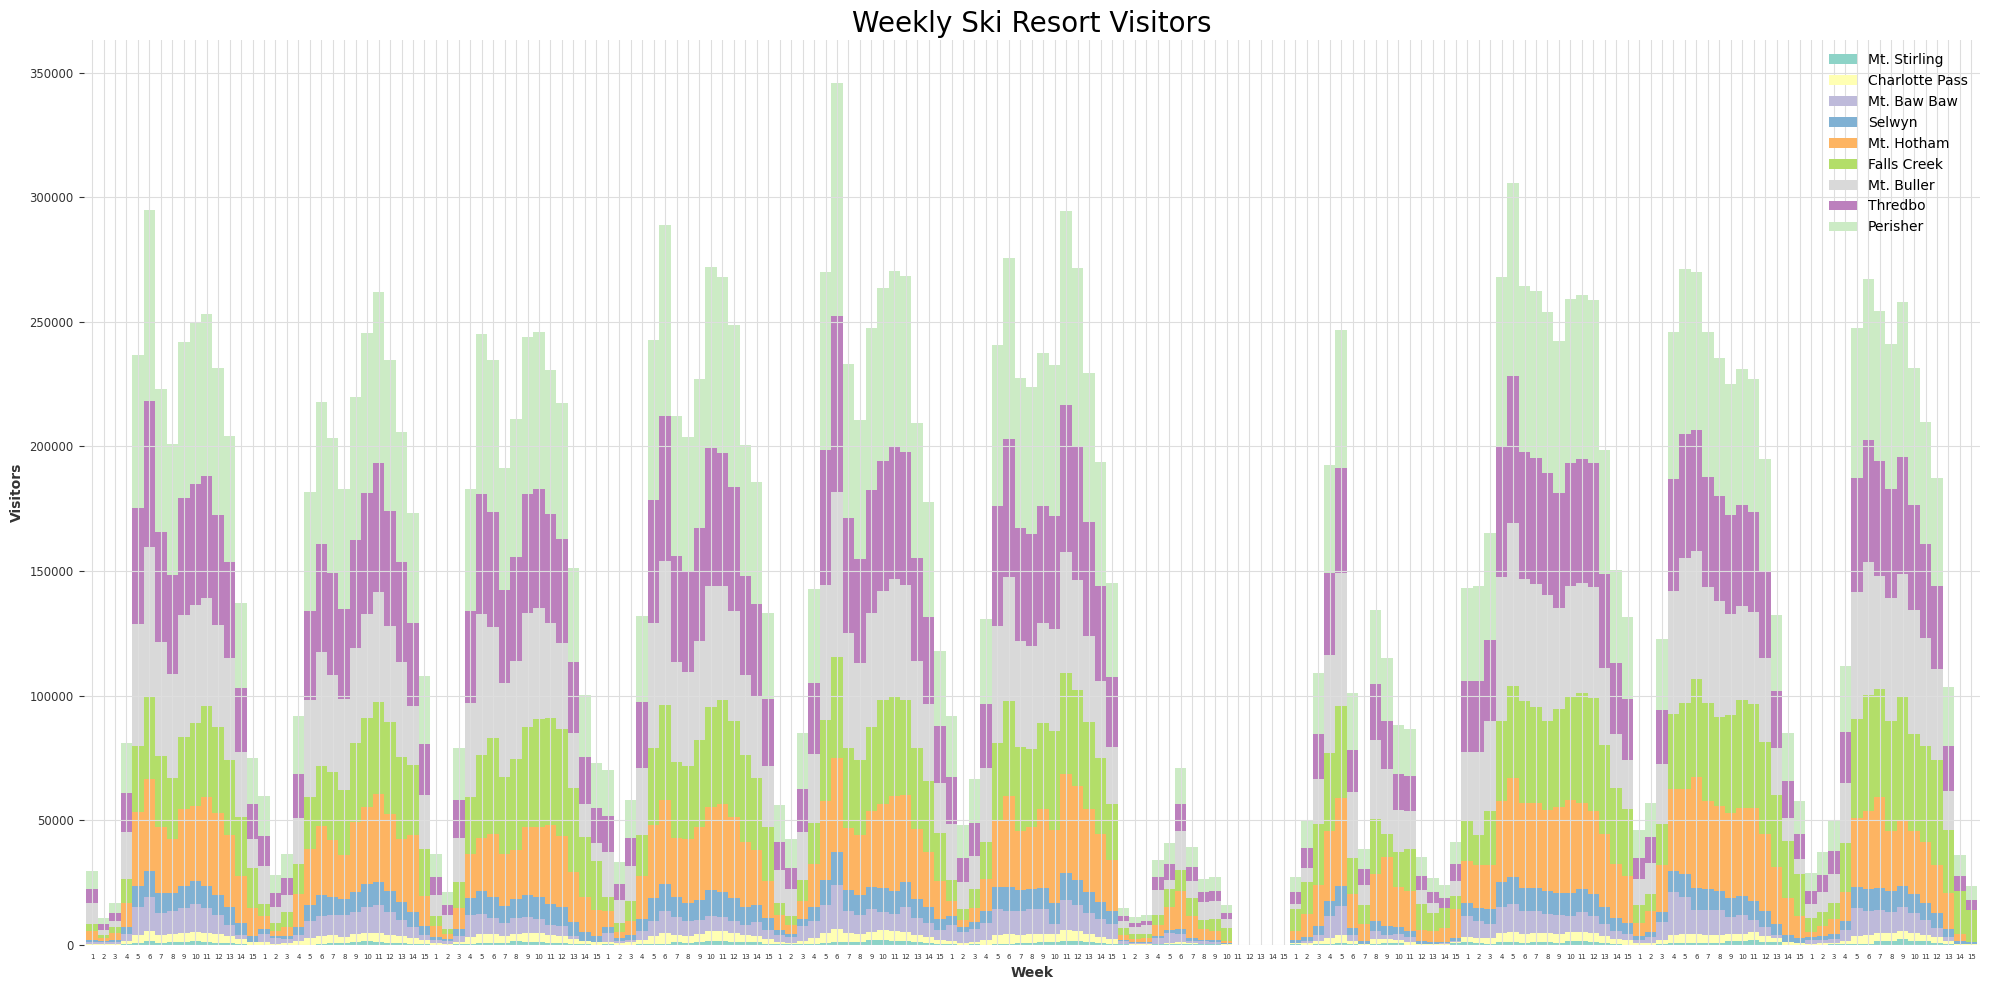

In [12]:
df_area = visitDataObj.data.copy()
df_area = df_area.drop(columns=['Year', 'Week'], errors='ignore')
df_area.set_index('Dates', inplace=True)

sorted_cols = df_area.sum().sort_values().index
df_area = df_area[sorted_cols]

colormap = matplotlib.colormaps.get_cmap('Set3')
colors = [colormap(i / df_area.shape[1]) for i in range(df_area.shape[1])]

df_area.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors, width=1)

plt.title("Weekly Ski Resort Visitors", fontsize=20)
plt.ylabel("Visitors")
plt.xlabel("Week")

num_weeks = df_area.shape[0]
xtick_labels = [(i % 15) + 1 for i in range(num_weeks)]
plt.xticks(ticks=range(num_weeks), labels=xtick_labels, rotation=0, fontsize=5)
plt.tight_layout()
plt.savefig("weekly_visitors.png", dpi=300)
plt.show()

### Inference (To do)
* Week 2 has the lowest amount of people
* We observe the double peaks during season with middle of the peaks having less people
* The trough of the peaks is moving right as time progresses
* 2020 data and 2021 are invalid beacuse of COVID policy and pandemic restrictions
    * Along with this, 2022 data cannot be used as the 1st, 2nd, 3rd weeks present huge outliers when we do SARIMA modelling. Since SARIMA takes into account only 11 data points for each week of the 15 week 'season' (Years), each point has higher leverage and outliers should be discarded.
    * The 2022 data having abnormally high numbers for first few weeks is likely a result of temporary increases in visitors as restrictions are loosened. However, this being temporary we shouldn't use this to predict future data where we do not expect something as drastic as COVID to happen again.

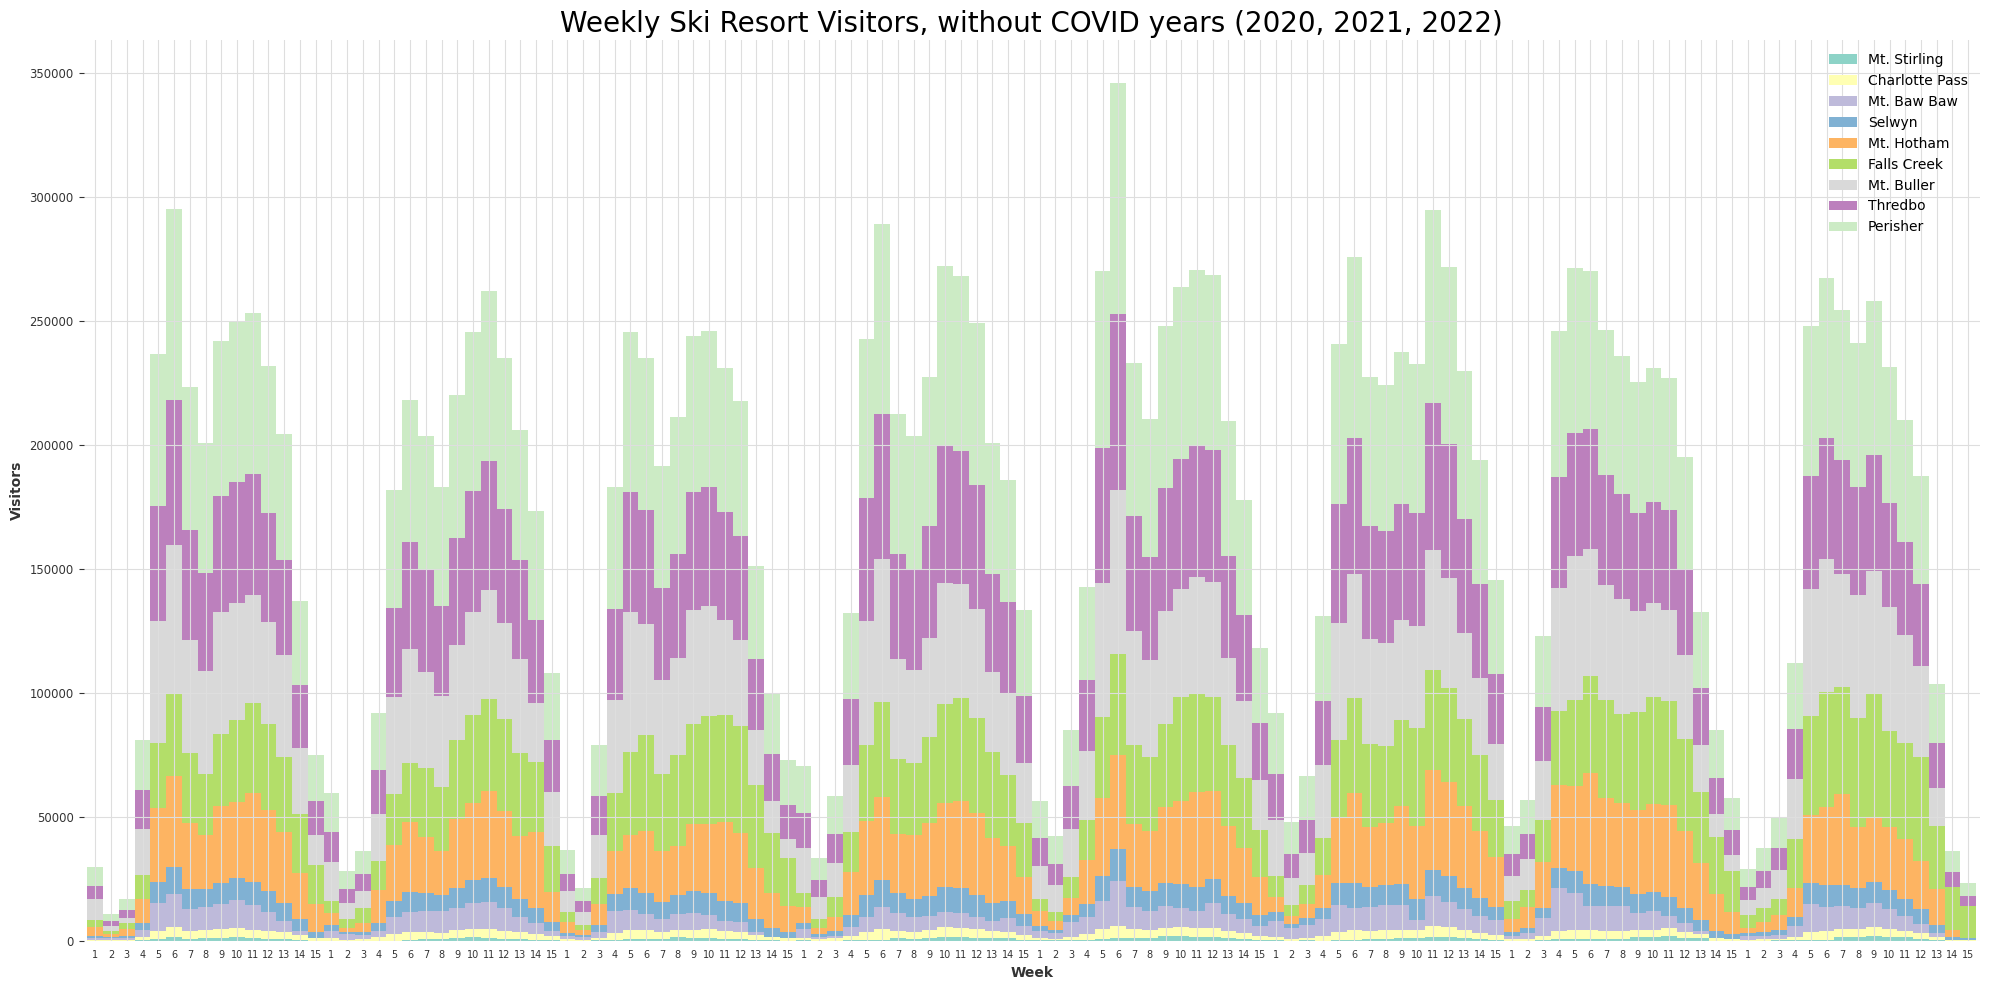

In [14]:
visitData_sliced = visitDataObj.data[~visitDataObj.data['Dates'].dt.year.isin([2020, 2021, 2022])]

df_area = visitData_sliced.copy()
df_area = df_area.drop(columns=['Year', 'Week'], errors='ignore')
df_area.set_index('Dates', inplace=True)

sorted_cols = df_area.sum().sort_values().index
df_area = df_area[sorted_cols]

colormap = matplotlib.colormaps.get_cmap('Set3')
colors = [colormap(i / df_area.shape[1]) for i in range(df_area.shape[1])]

df_area.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors, width=1)

plt.title("Weekly Ski Resort Visitors, without COVID years (2020, 2021, 2022)", fontsize=20)
plt.ylabel("Visitors")
plt.xlabel("Week")

num_weeks = df_area.shape[0]
xtick_labels = [(i % 15) + 1 for i in range(num_weeks)]
plt.xticks(ticks=range(num_weeks), labels=xtick_labels, rotation=0, fontsize=7)

plt.tight_layout()
plt.savefig("weekly_visitors_AFTERCLEAN.png", dpi=300)

plt.show()

### Inference
* Our cleaned dataset. Notice the seasonality of the data. This means that SARIMA, exponential smoothing and deep learning models may be a good fit for the data as they account for seasonality.

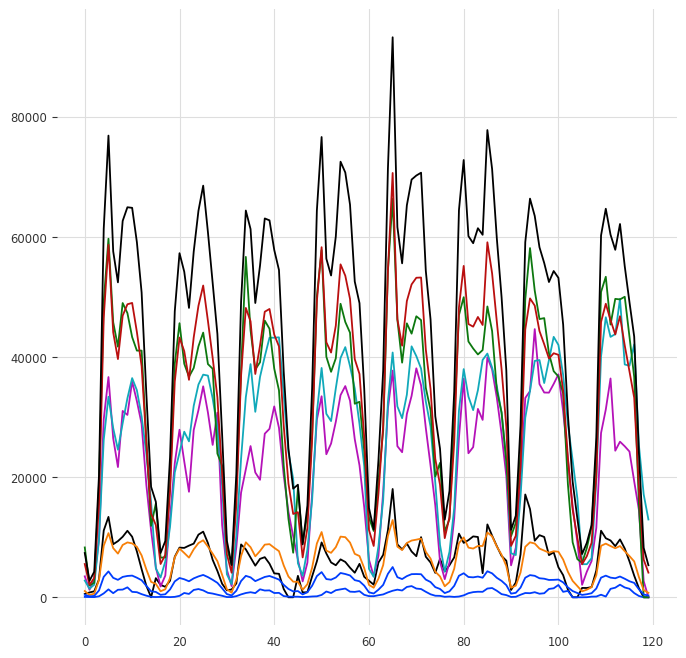

In [16]:
cleaned_visit = visitData_sliced.reset_index(drop=True).drop(['Dates'], axis = 1)
fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(cleaned_visit);

### Inference
* Seasonality is further evidenced here. We can also see the bi-peaks in every season.
* The data may be able to be autoregressed as it seems every week looks to be correlated to the same week the seasons before.

# Visitation Model Selection

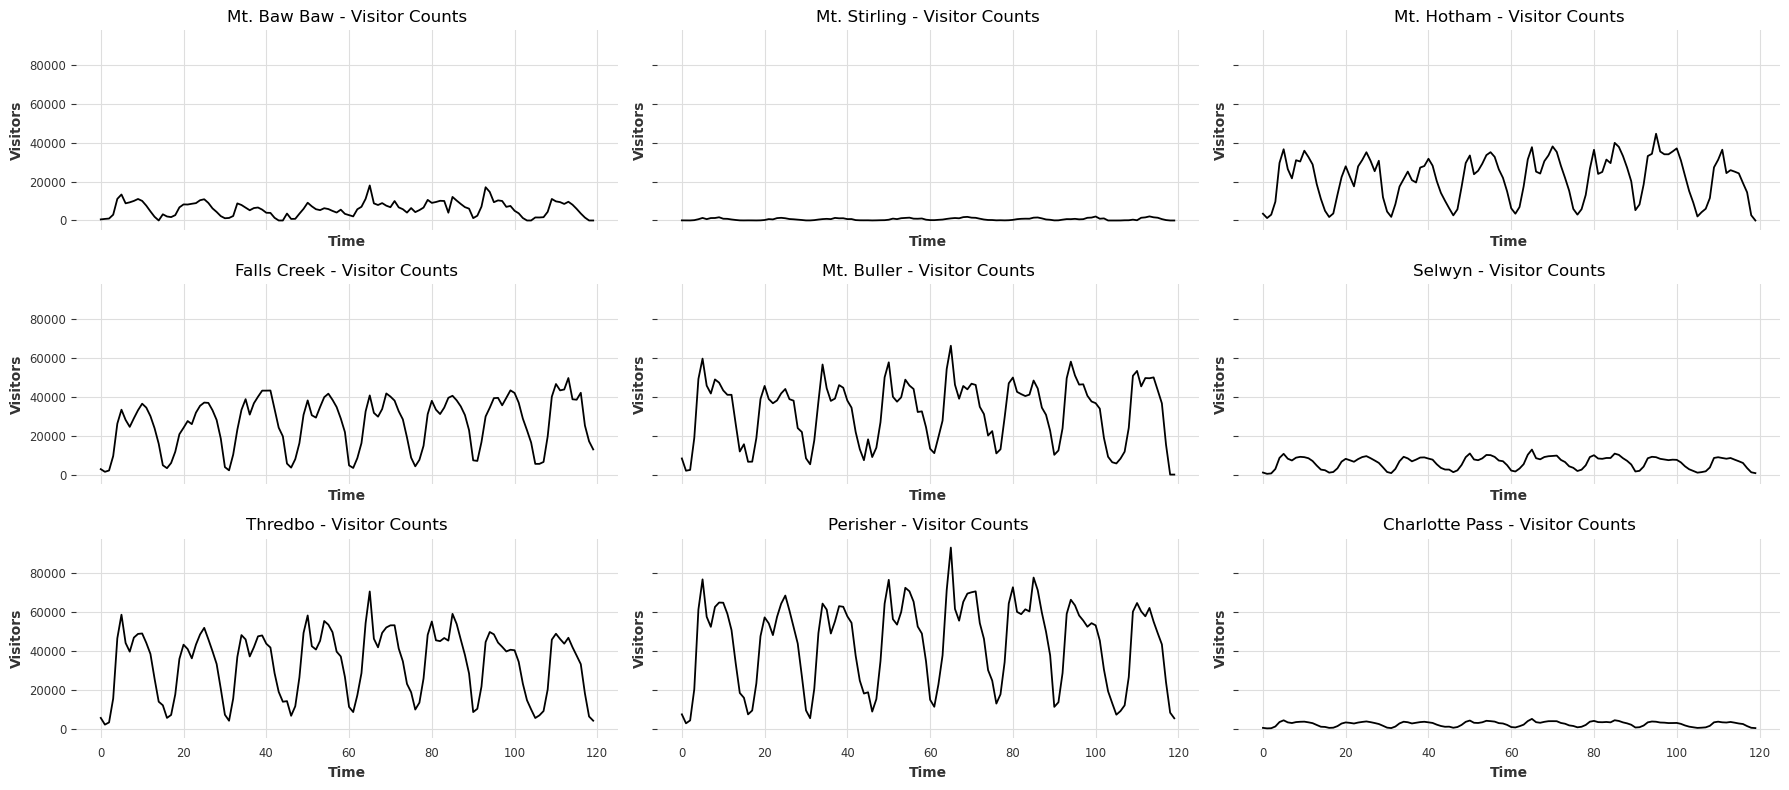

In [19]:
series_list = []
resort_columns = cleaned_visit.columns[0:9]

fig, axes = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, col in enumerate(resort_columns):
    series = cleaned_visit[col].to_numpy()
    series_list.append(series)

    axes[i].plot(series)
    axes[i].set_title(f"{col} - Visitor Counts")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Visitors")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

series_array = np.array(series_list)

### Inferences
* Apart from Mt. Baw Baw, the data shows seasonality meaning that exponential smoothing and SARIMA can be applied.

In [21]:
num_series, num_timesteps = series_array.shape

time_index = pd.date_range(start='2000-01-01', periods=num_timesteps, freq='W-MON')
ts_array = []

for i in range(num_series):
    df = pd.DataFrame({
        'Time': time_index,
        'Value': series_array[i]
    })

    ts = TimeSeries.from_dataframe(df, time_col='Time', value_cols='Value', fill_missing_dates=False)
    ts_array.append(ts)

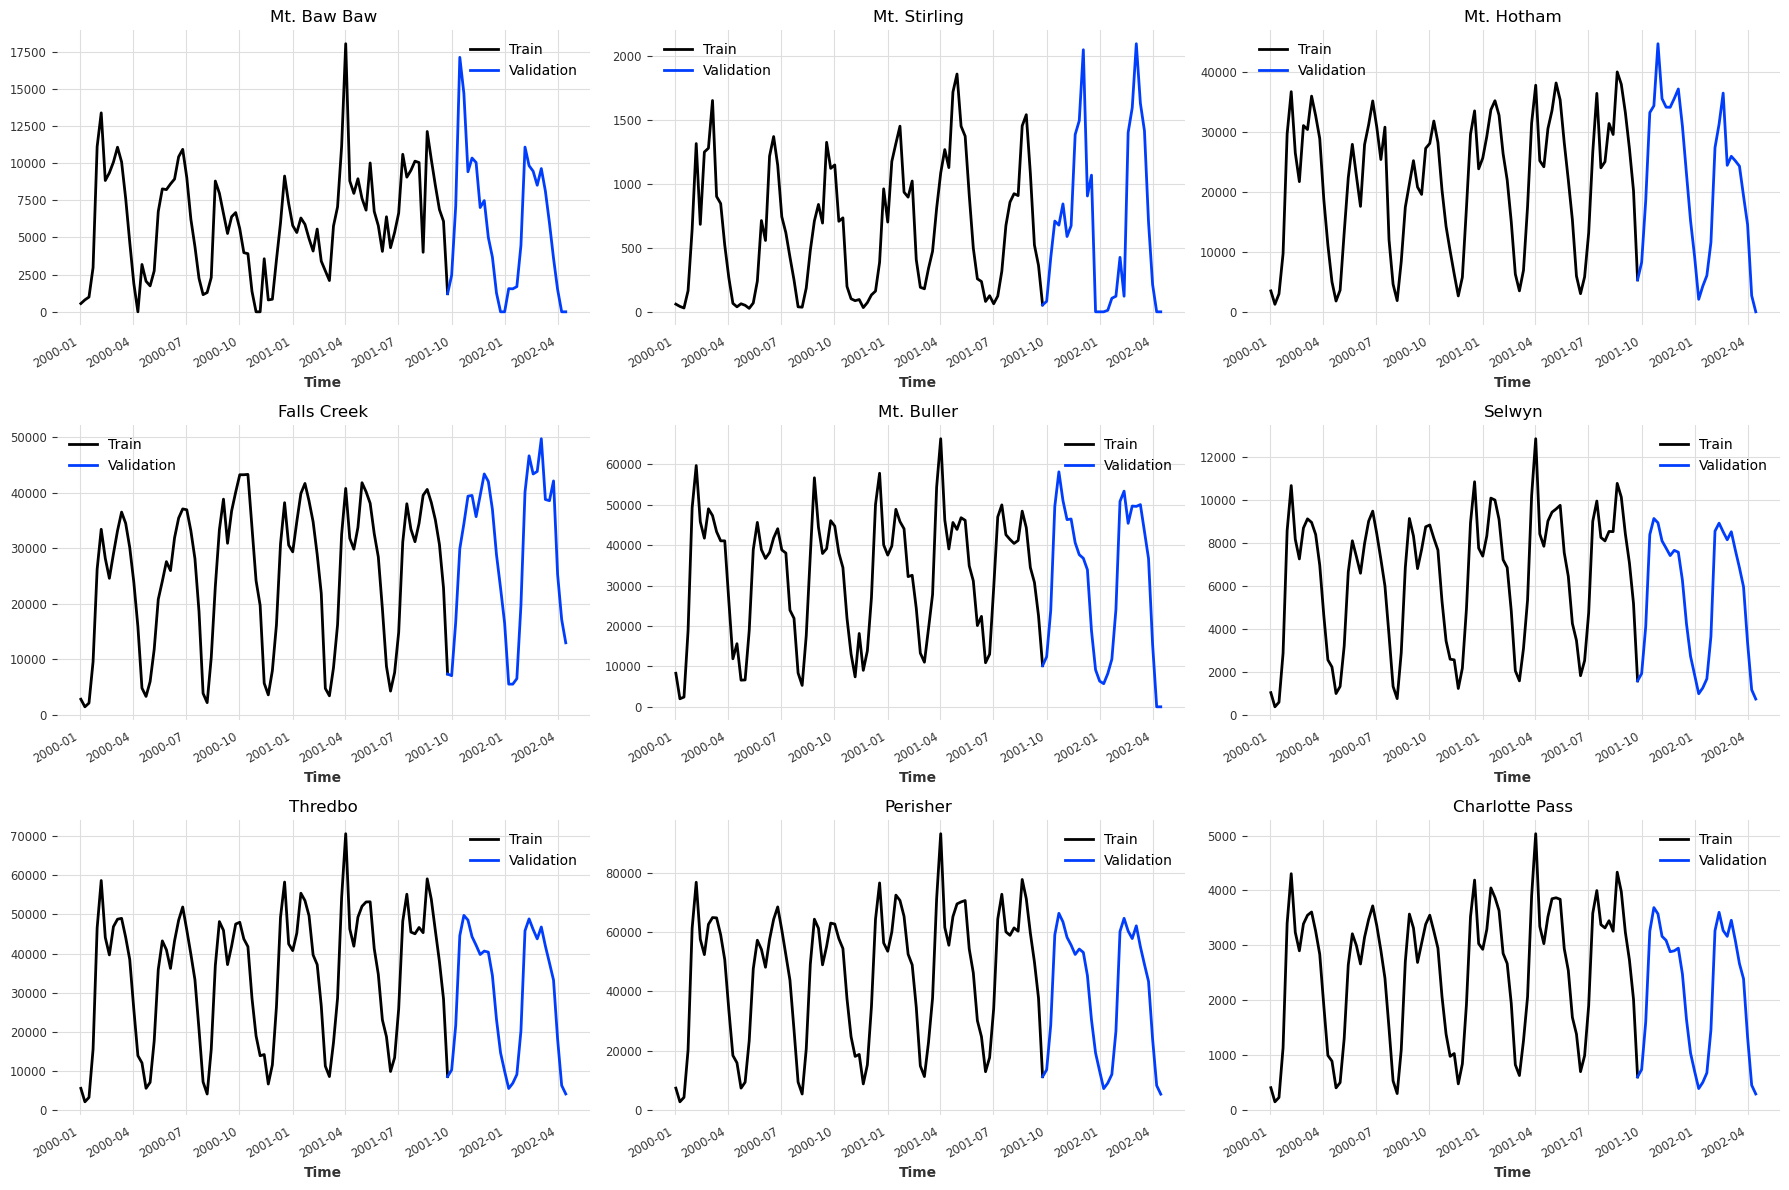

In [22]:
col_names = visitDataObj.data.columns[1:10]

train_array = []
val_array = []

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (ts, name) in enumerate(zip(ts_array[:9], col_names)):
    train = ts[:-29]
    val = ts[-30:]

    train_array.append(train)
    val_array.append(val)

    ax = axs[i]
    train.plot(ax=ax, label='Train')
    val.plot(ax=ax, label='Validation')
    ax.set_title(name)
    ax.legend()

for j in range(len(ts_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

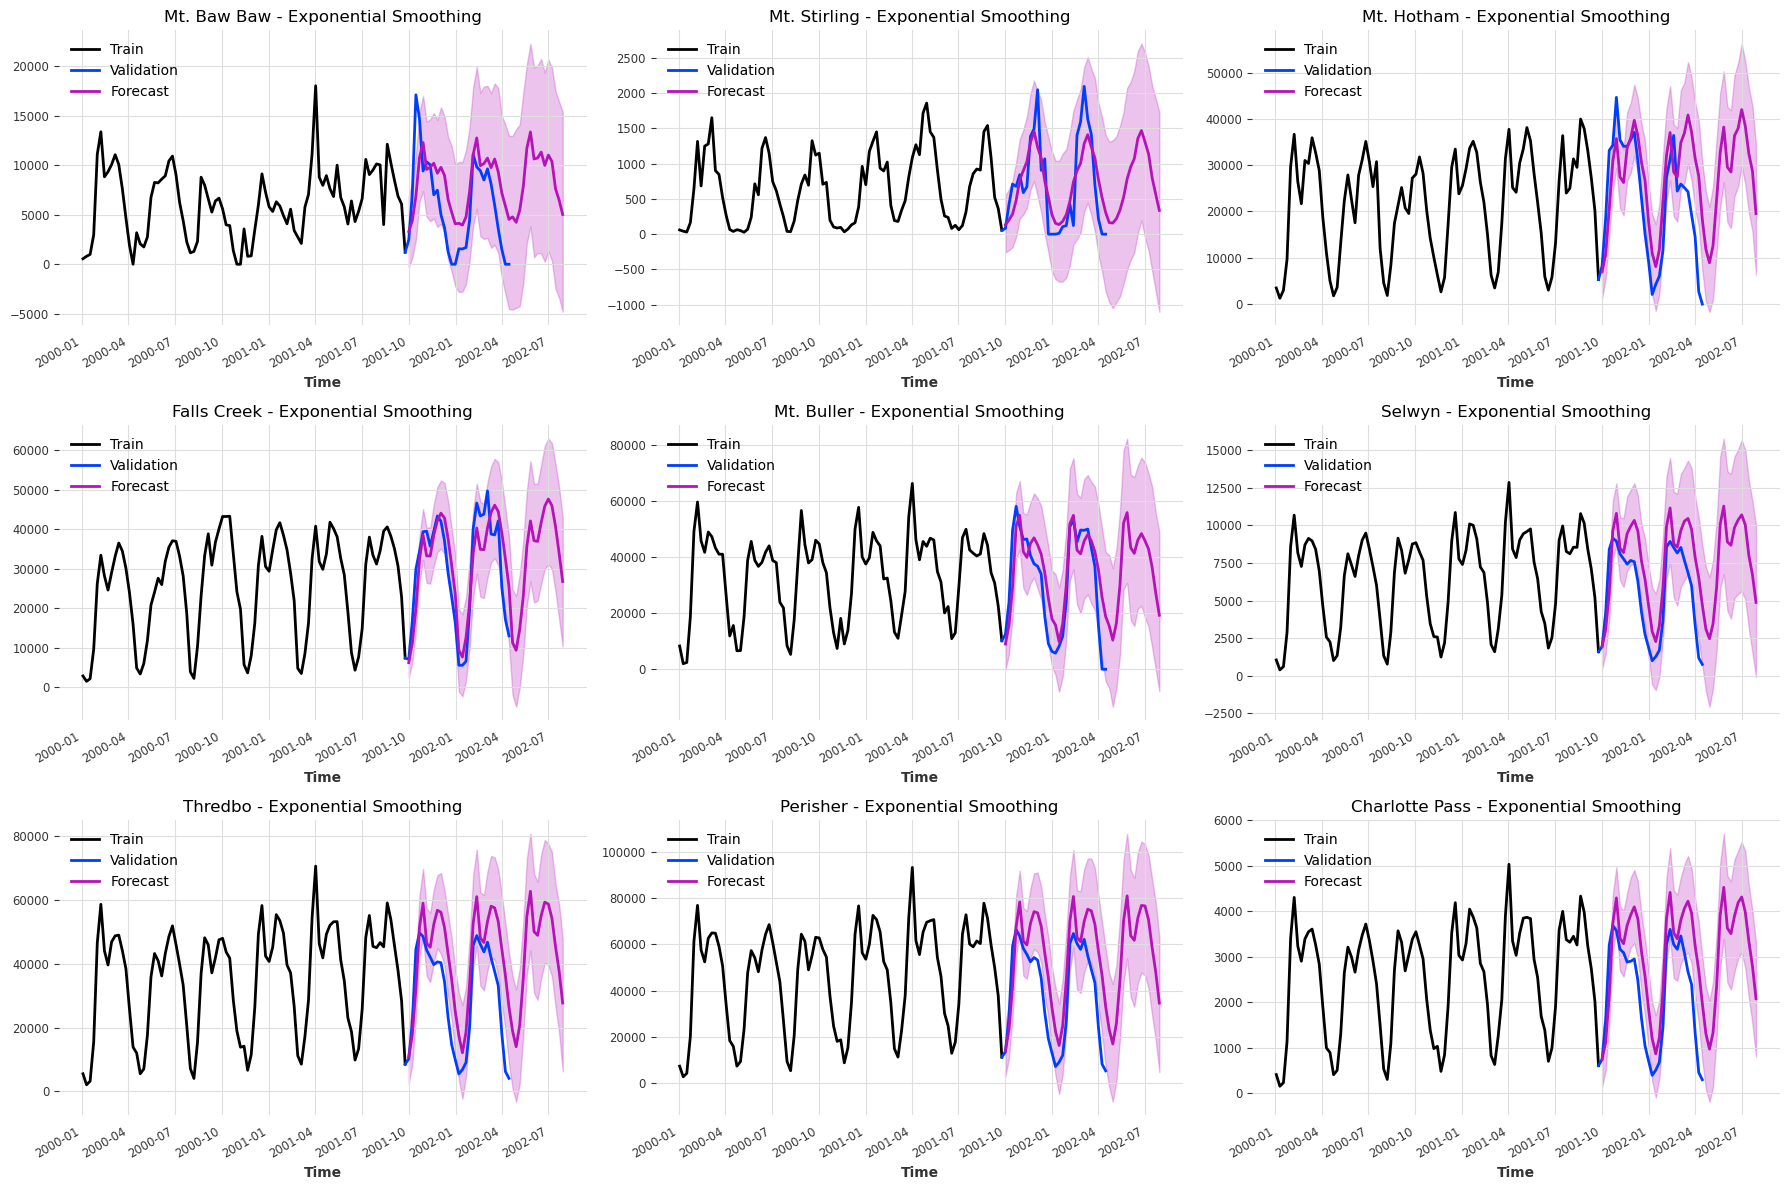

In [23]:
col_names = visitDataObj.data.columns[1:10]

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (train, val, name) in enumerate(zip(train_array, val_array, col_names)):
    model = ExponentialSmoothing(seasonal_periods=15)
    model.fit(train)
    prediction = model.predict(len(val) + 14, num_samples=1000)

    ax = axs[i]
    train.plot(ax=ax, label="Train")
    val.plot(ax=ax, label="Validation")
    prediction.plot(ax=ax, label="Forecast", low_quantile=0.05, high_quantile=0.95)

    ax.set_title(f"{name} - Exponential Smoothing")
    ax.legend()

for j in range(len(train_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

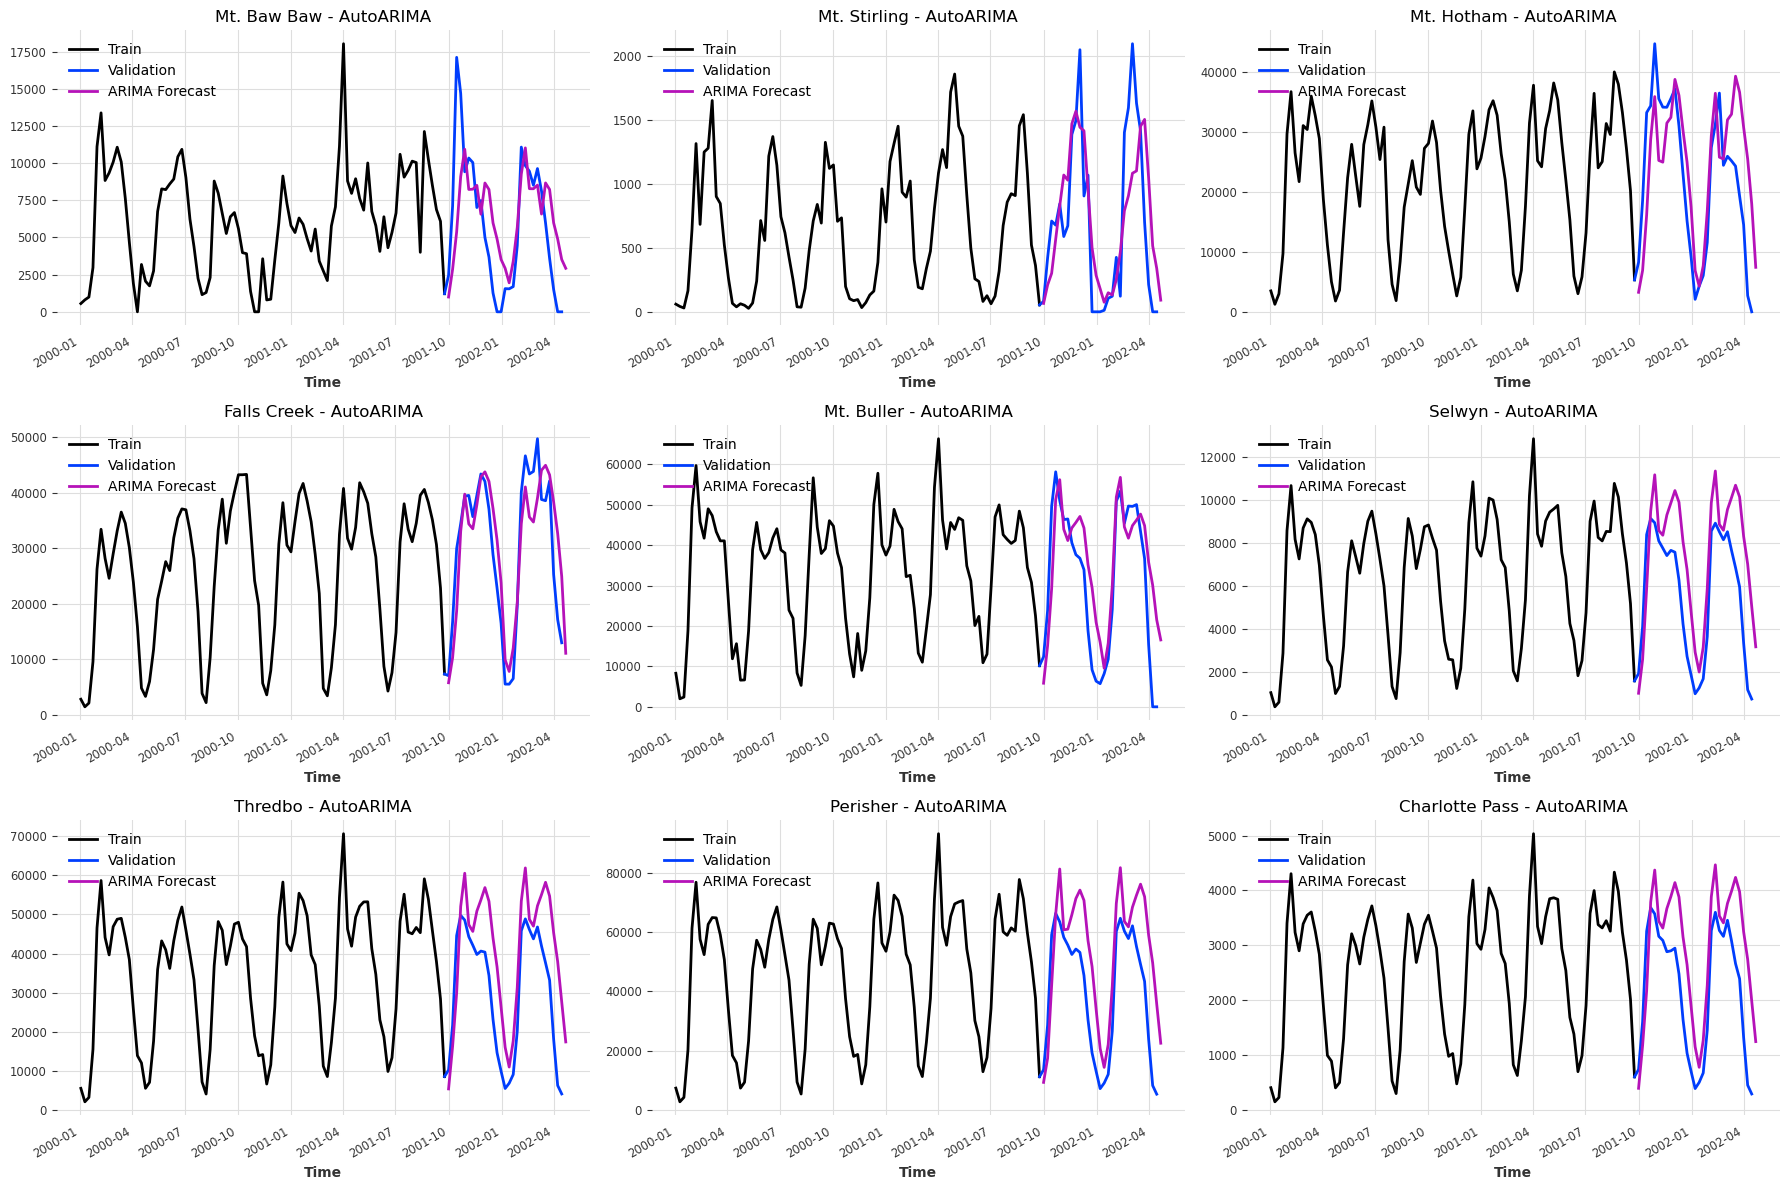

In [24]:
col_names = visitDataObj.data.columns[1:10]  # Names for the plots

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (train, val, name) in enumerate(zip(train_array, val_array, col_names)):
    model_arima = AutoARIMA(season_length=15)
    model_arima.fit(train)
    forecast_arima = model_arima.predict(len(val))

    ax = axs[i]
    train.plot(ax=ax, label="Train")
    val.plot(ax=ax, label="Validation")
    forecast_arima.plot(ax=ax, label="ARIMA Forecast")

    ax.set_title(f"{name} - AutoARIMA")
    ax.legend()

for j in range(len(train_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

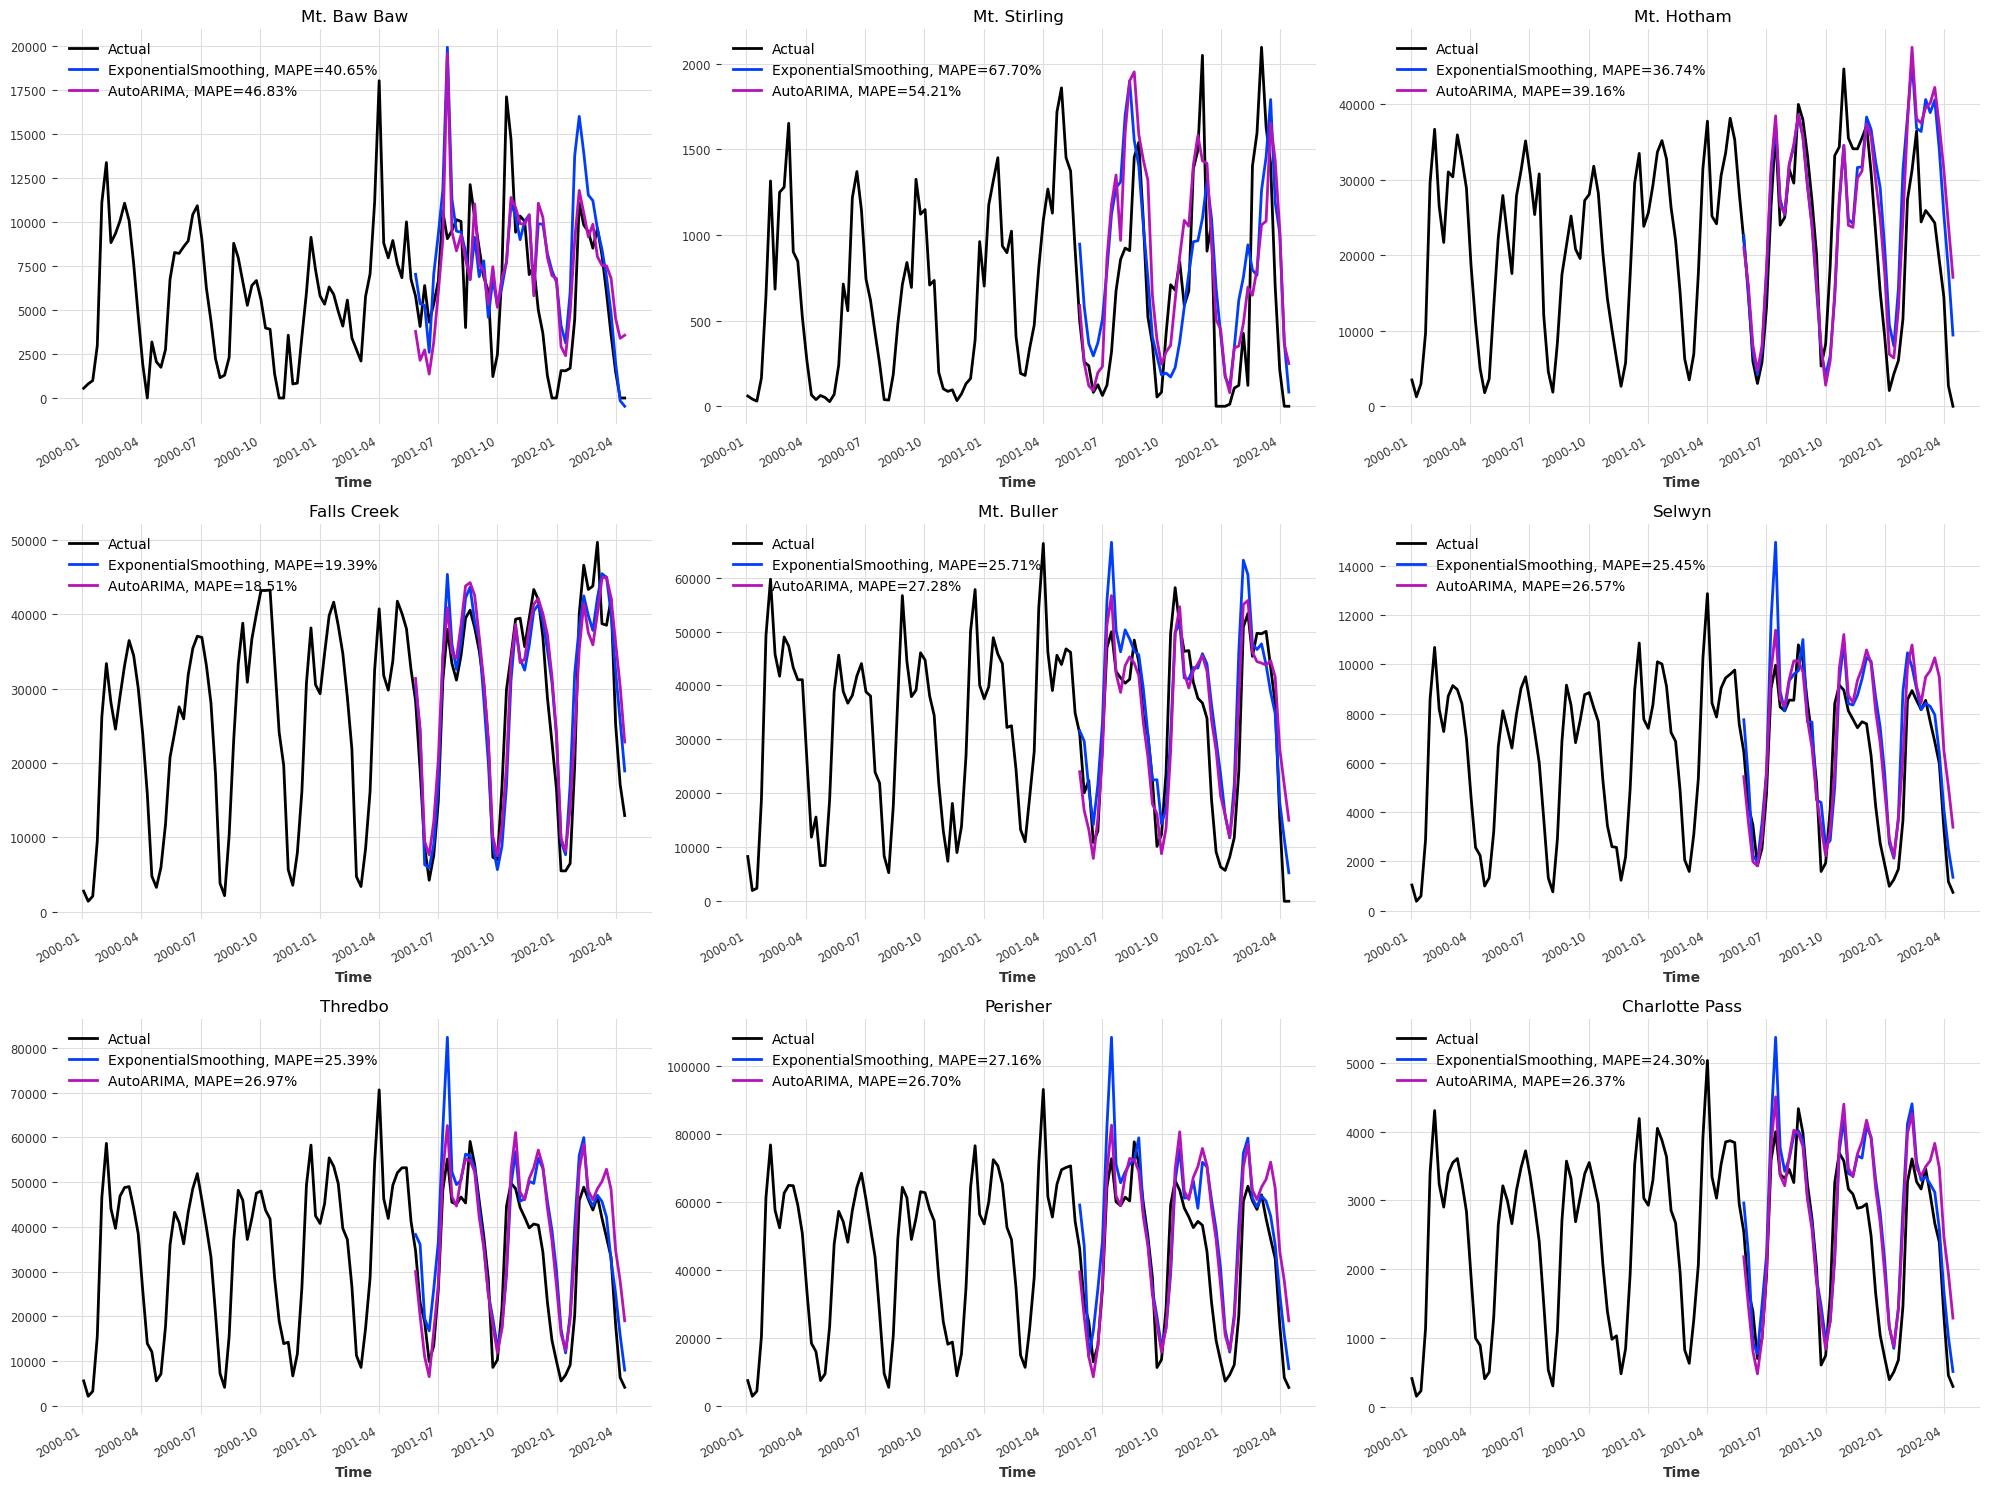

In [25]:
col_names = visitDataObj.data.columns[1:10]

fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, (ts, name) in enumerate(zip(ts_array, col_names)):
    models = [
        ExponentialSmoothing(seasonal_periods=15),
        AutoARIMA(season_length=15)
    ]

    backtests = [
        model.historical_forecasts(
            ts, start=0.5, forecast_horizon=15,
            stride=1, retrain=True, verbose=False
        ) for model in models
    ]

    ax = axs[i]
    ts.plot(ax=ax, label='Actual', lw=2)

    for model, bt in zip(models, backtests):
        err = mape(bt, ts.drop_before(bt.start_time()))
        bt.plot(ax=ax, label=f'{model.__class__.__name__}, MAPE={err:.2f}%')

    ax.set_title(f"{name}")
    ax.legend()

for j in range(len(ts_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Inferences
* From our backtests we see that different models produced smaller MAPEs on different resort datasets. To avoid overfitting, we concluded that exponential smoothing best fit our purposes as it has the lowest overall MAPE.
* Trough of the data consistently occurs at around week 8.

# Climate Data Model Selection

## Maximum Temperature

In [28]:
climateDataRaw = xls.parse('Climate Data')
climateData_maxtemp = climateDataRaw[[
    'Bureau of Meteorology station number',
    'Year',
    'Month',
    'Day',
    'Maximum temperature (Degree C)'
]]
climateData_maxtemp

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C)
0,71075,2010,1,1,NaN
1,71075,2010,1,2,NaN
2,71075,2010,1,3,NaN
3,71075,2010,1,4,NaN
4,71075,2010,1,5,NaN
...,...,...,...,...,...
39808,72161,2025,7,24,3.0
39809,72161,2025,7,25,6.0
39810,72161,2025,7,26,2.7
39811,72161,2025,7,27,2.5


In [29]:
station_ids = [71032, 71075, 72161, 83024, 83084, 83085, 85291]
climate_datasets = []

for station_id in station_ids:
    obj = climateClean(climateData_maxtemp.copy())
    obj.fromYMDtoDates()
    obj.filterStation(station_id)
    climate_datasets.append(obj.data)

climate_datasets = [df.fillna(method='ffill') for df in climate_datasets]

exog_cols = [
    'Maximum temperature (Degree C)',
]

ts_array = []

for i, df in enumerate(climate_datasets):
    df = df.copy()

    # ensure datetime & sorted
    df['Dates'] = pd.to_datetime(df['Dates'])
    df = df.sort_values('Dates')

    # set daily frequency & fill gaps BEFORE making the TimeSeries (robust for any Darts version)
    df = df.set_index('Dates').asfreq('D')

    # forward-fill then back-fill to remove NaNs (pick the policy you prefer)
    df[exog_cols] = df[exog_cols].ffill().bfill()

    # build multivariate TimeSeries (3 components: max/min temp, rain)
    ts = TimeSeries.from_dataframe(
        df.reset_index(),
        time_col='Dates',
        value_cols=exog_cols,
        fill_missing_dates=False  # already regular at 'D'
    )
    ts_array.append(ts)

len(ts_array), ts_array[0].components

/var/folders/st/vt6hxj_93517y4vp9mxflvn80000gn/T/ipykernel_12256/939280317.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  climate_datasets = [df.fillna(method='ffill') for df in climate_datasets]


(7, Index(['Maximum temperature (Degree C)'], dtype='object'))

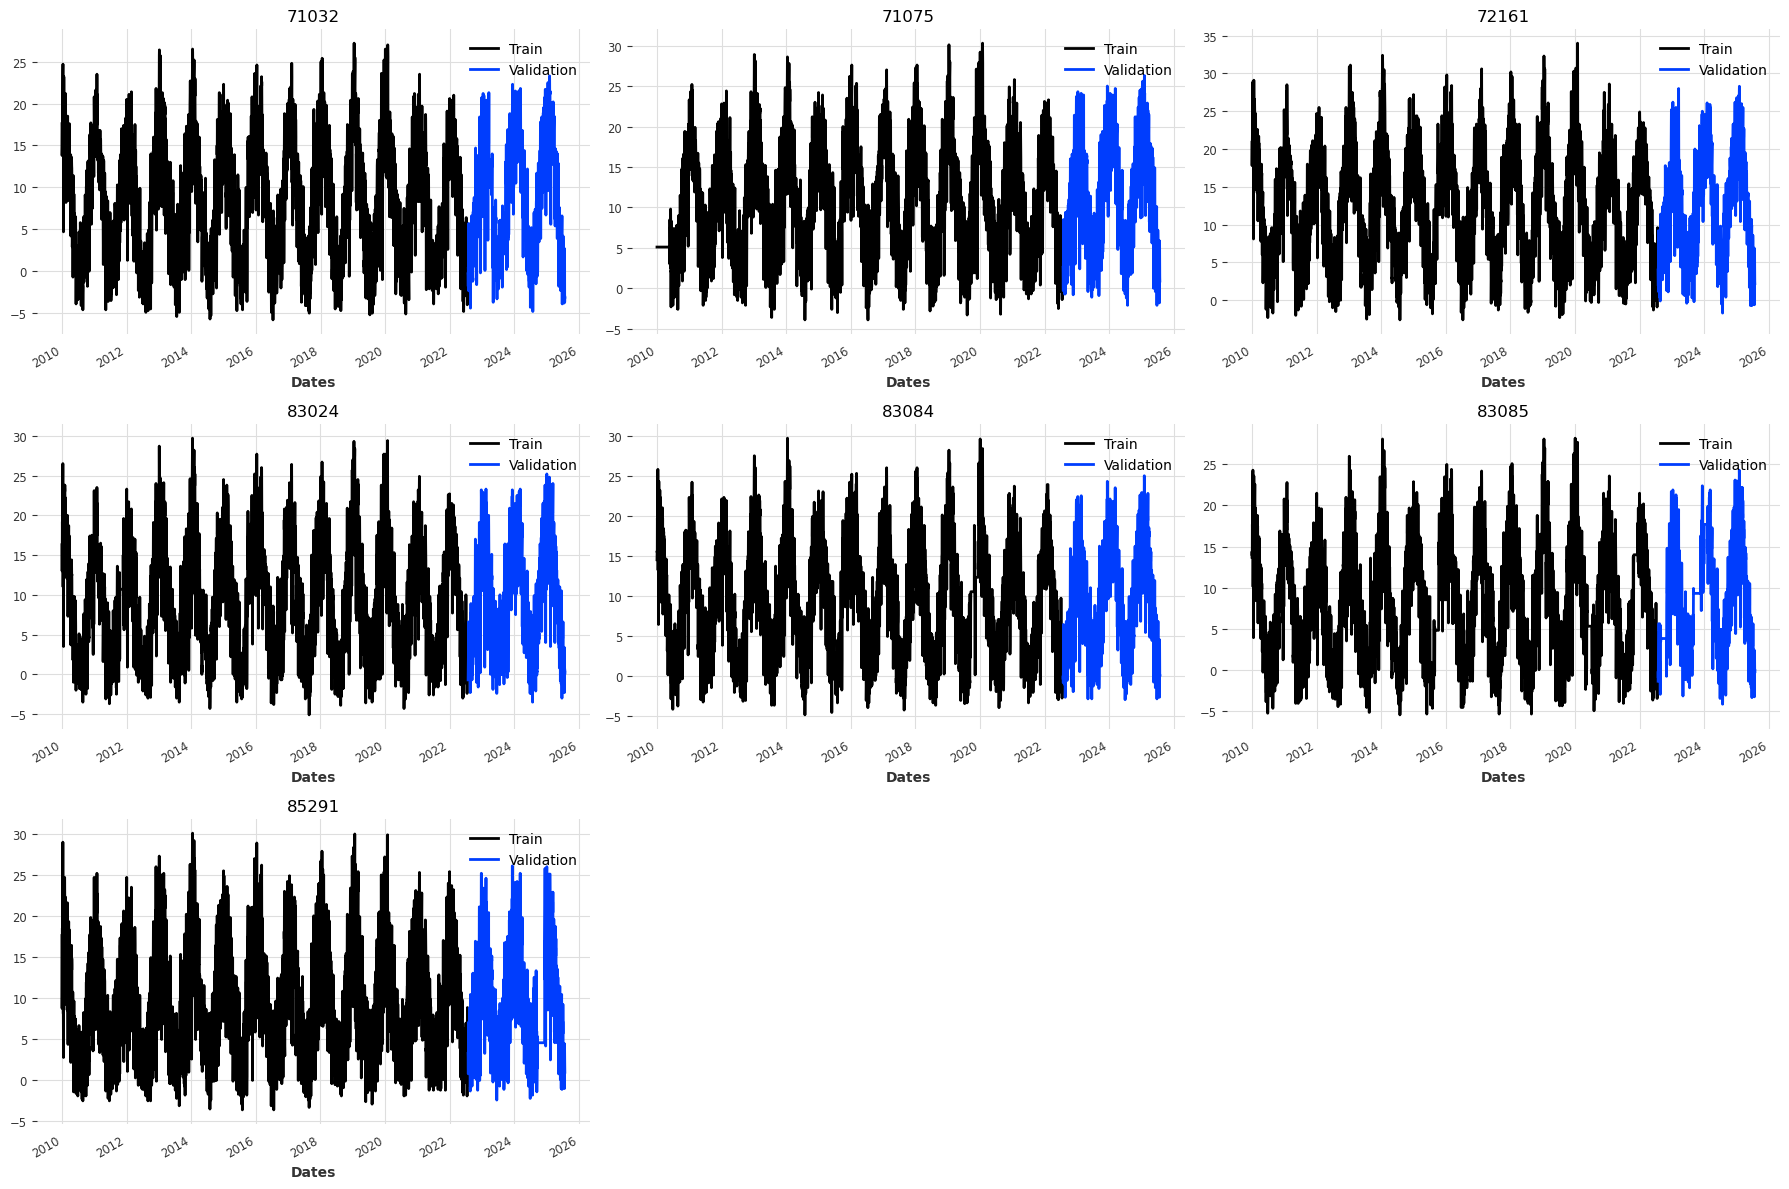

In [59]:
col_names = [71032, 71075, 72161, 83024, 83084, 83085, 85291]

train_array = []
val_array = []

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (ts, name) in enumerate(zip(ts_array[:9], col_names)):
    train = ts[:-(365 * 3 -1)]
    val = ts[-365 * 3:]

    train_array.append(train)
    val_array.append(val)

    ax = axs[i]
    train.plot(ax=ax, label='Train')
    val.plot(ax=ax, label='Validation')
    ax.set_title(name)
    ax.legend()

for j in range(len(ts_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (train, val, name) in enumerate(zip(train_array, val_array, col_names)):
    model_arima = AutoARIMA(season_length=365)
    model_arima.fit(train)
    forecast_arima = model_arima.predict(len(val))

    ax = axs[i]
    train.plot(ax=ax, label="Train")
    val.plot(ax=ax, label="Validation")
    forecast_arima.plot(ax=ax, label="ARIMA Forecast")

    ax.set_title(f"{name} - AutoARIMA")
    ax.legend()

for j in range(len(train_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed

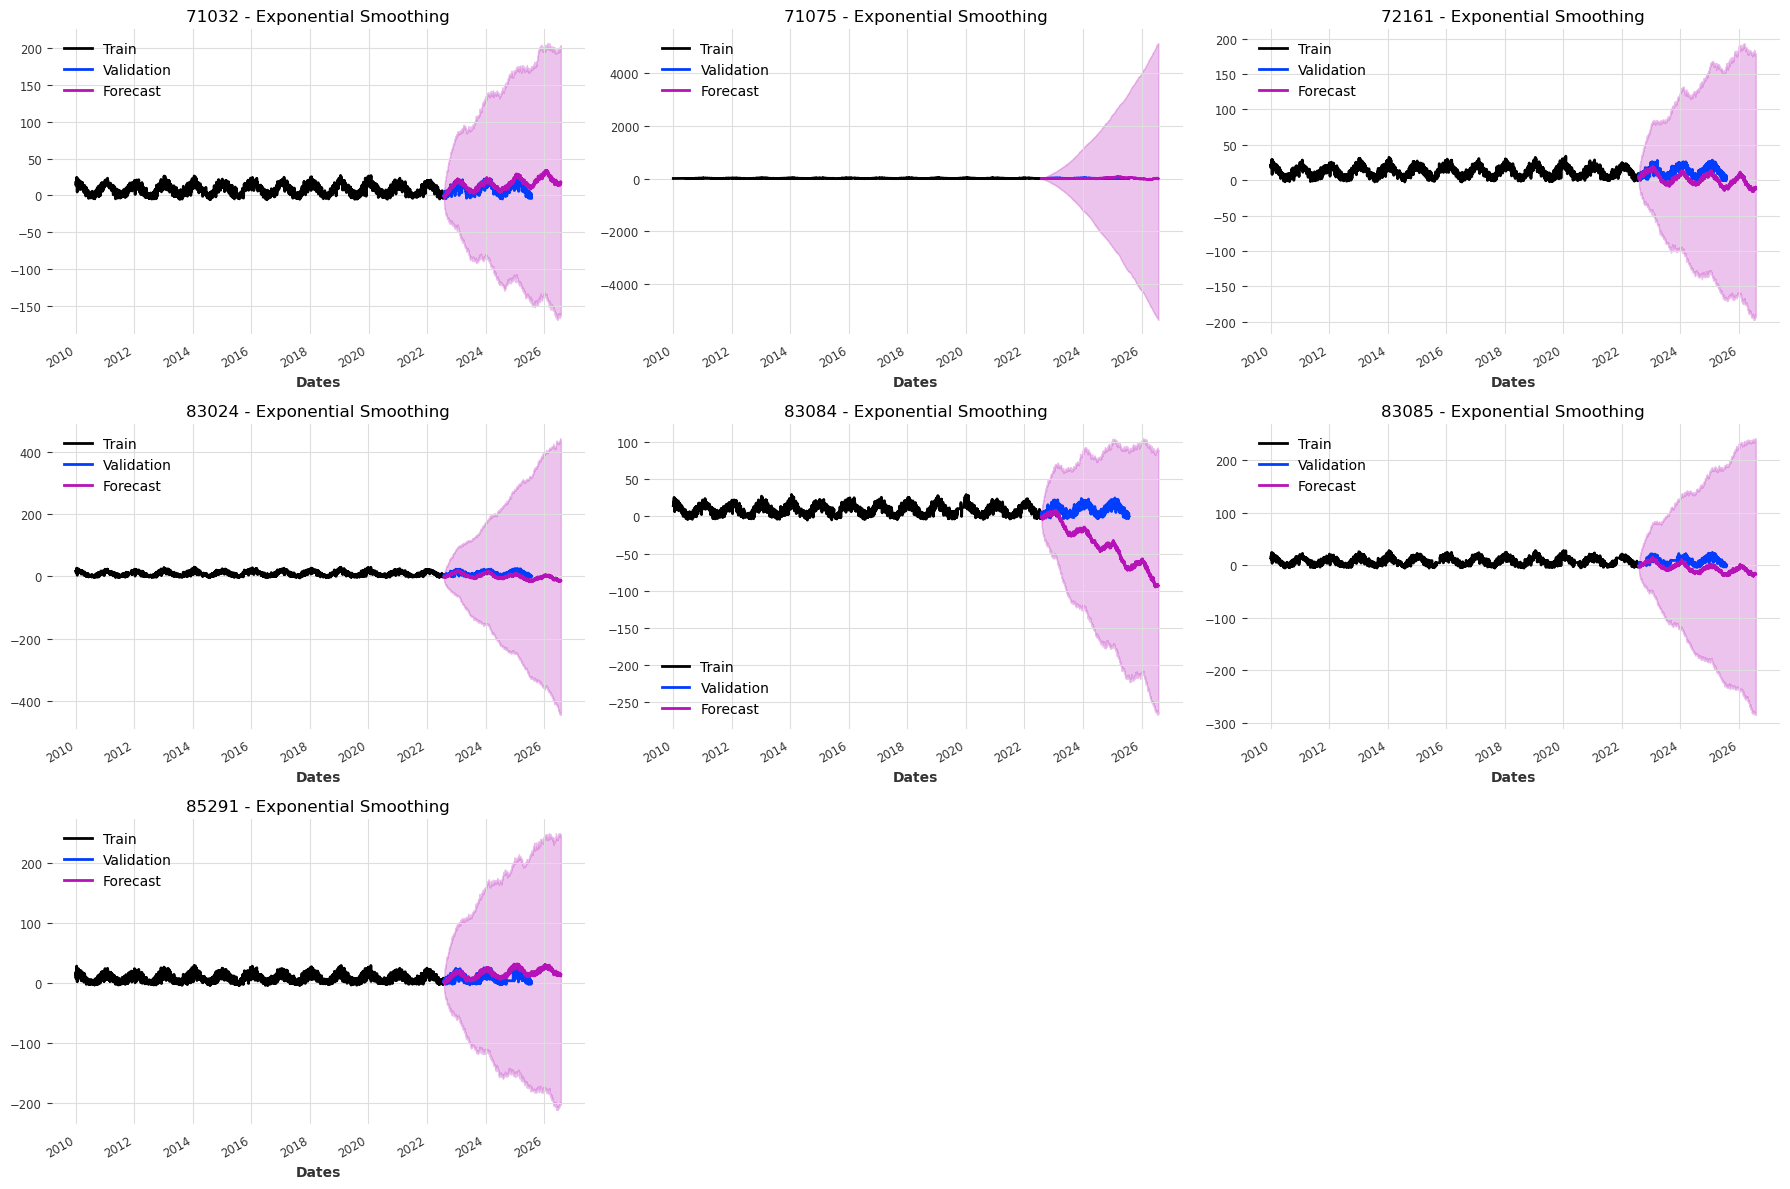

In [77]:
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (train, val, name) in enumerate(zip(train_array, val_array, col_names)):
    model = ExponentialSmoothing(seasonal_periods=365)
    model.fit(train)
    prediction = model.predict(len(val) + 365, num_samples=1000)

    ax = axs[i]
    train.plot(ax=ax, label="Train")
    val.plot(ax=ax, label="Validation")
    prediction.plot(ax=ax, label="Forecast", low_quantile=0.05, high_quantile=0.95)

    ax.set_title(f"{name} - Exponential Smoothing")
    ax.legend()

for j in range(len(train_array), 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()